In this notebook I will study the evolution of the NO2 concentration levels in the city of Madrid, Spain in the period of January 1st-April 30th 2020.

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

from covid19_pollution_func import * #Custom functions

from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
pollutant = 'NO2'

In [6]:
df = pd.read_csv('../clean_datasets/%s-2020.csv'%(pollutant), index_col=0, parse_dates=True)

In [7]:
df.head()

,estacion,concentracion
dt,,
2020-01-01,39,126.0
2020-01-01,16,71.0
2020-01-01,40,107.0
2020-01-01,47,67.0
2020-01-01,11,104.0


I'll be working with the average concentration throughout all stations per hour.

In [8]:
df = df.groupby('dt')['concentracion'].mean()
df = pd.DataFrame(df)

## Time series plots

In [9]:
tick_pos, tick_labels = half_month_ticks()

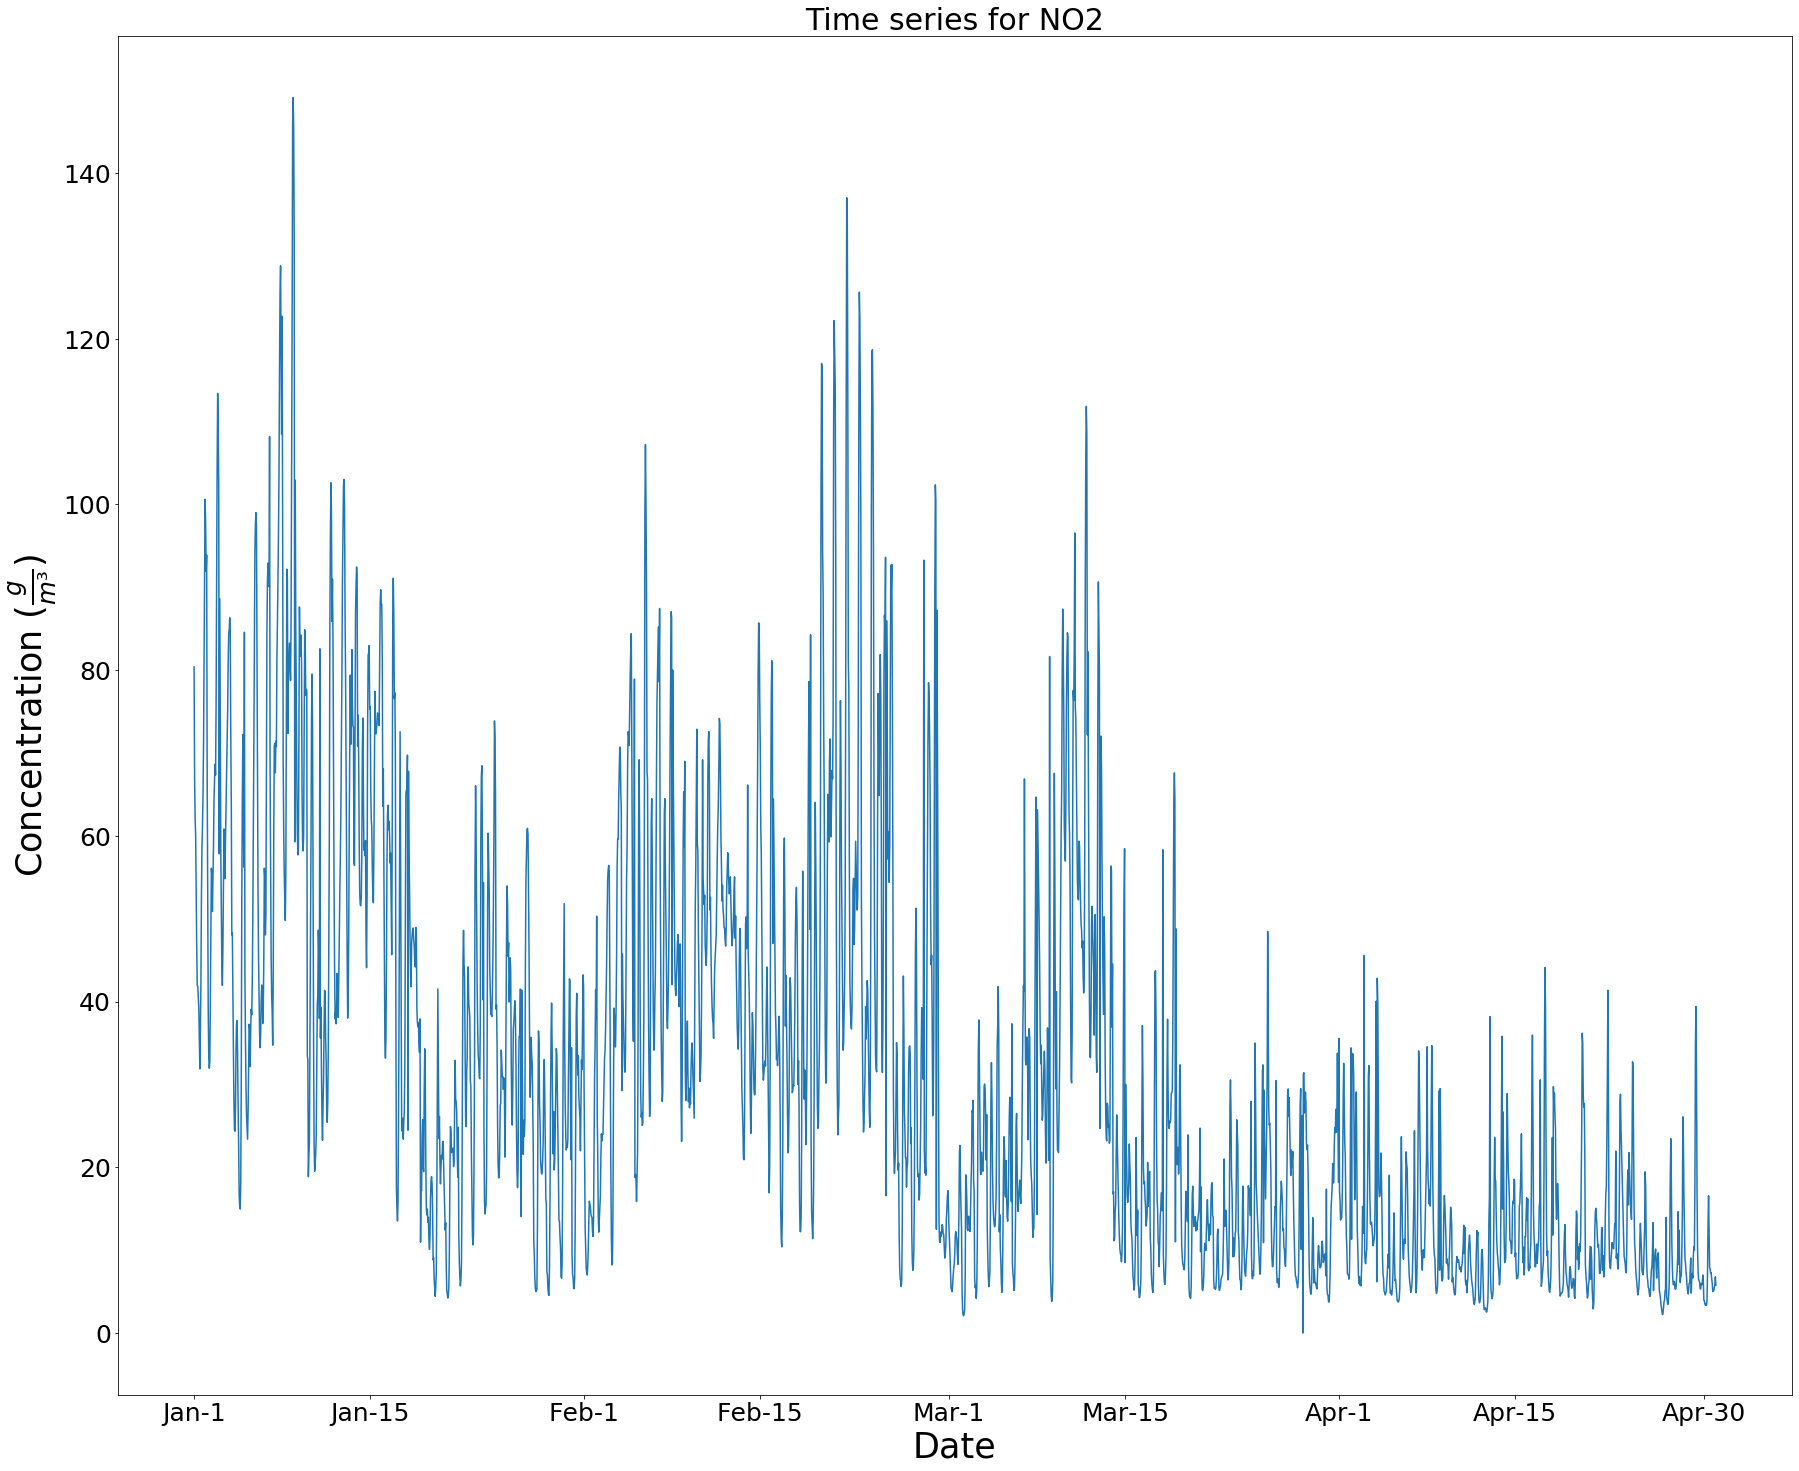

In [10]:
plt.figure(figsize=(30,25))
sns.lineplot(df.index, df['concentracion'])
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{g}{m³})$', fontsize=35)
plt.xticks(ticks=tick_pos, labels=tick_labels, fontsize=25)
plt.yticks(fontsize=25)
plt.title('Time series for ' + pollutant, fontsize=30);

I'll use a simple moving average to smooth out the curve.

In [11]:
df['SMA'] = df.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()

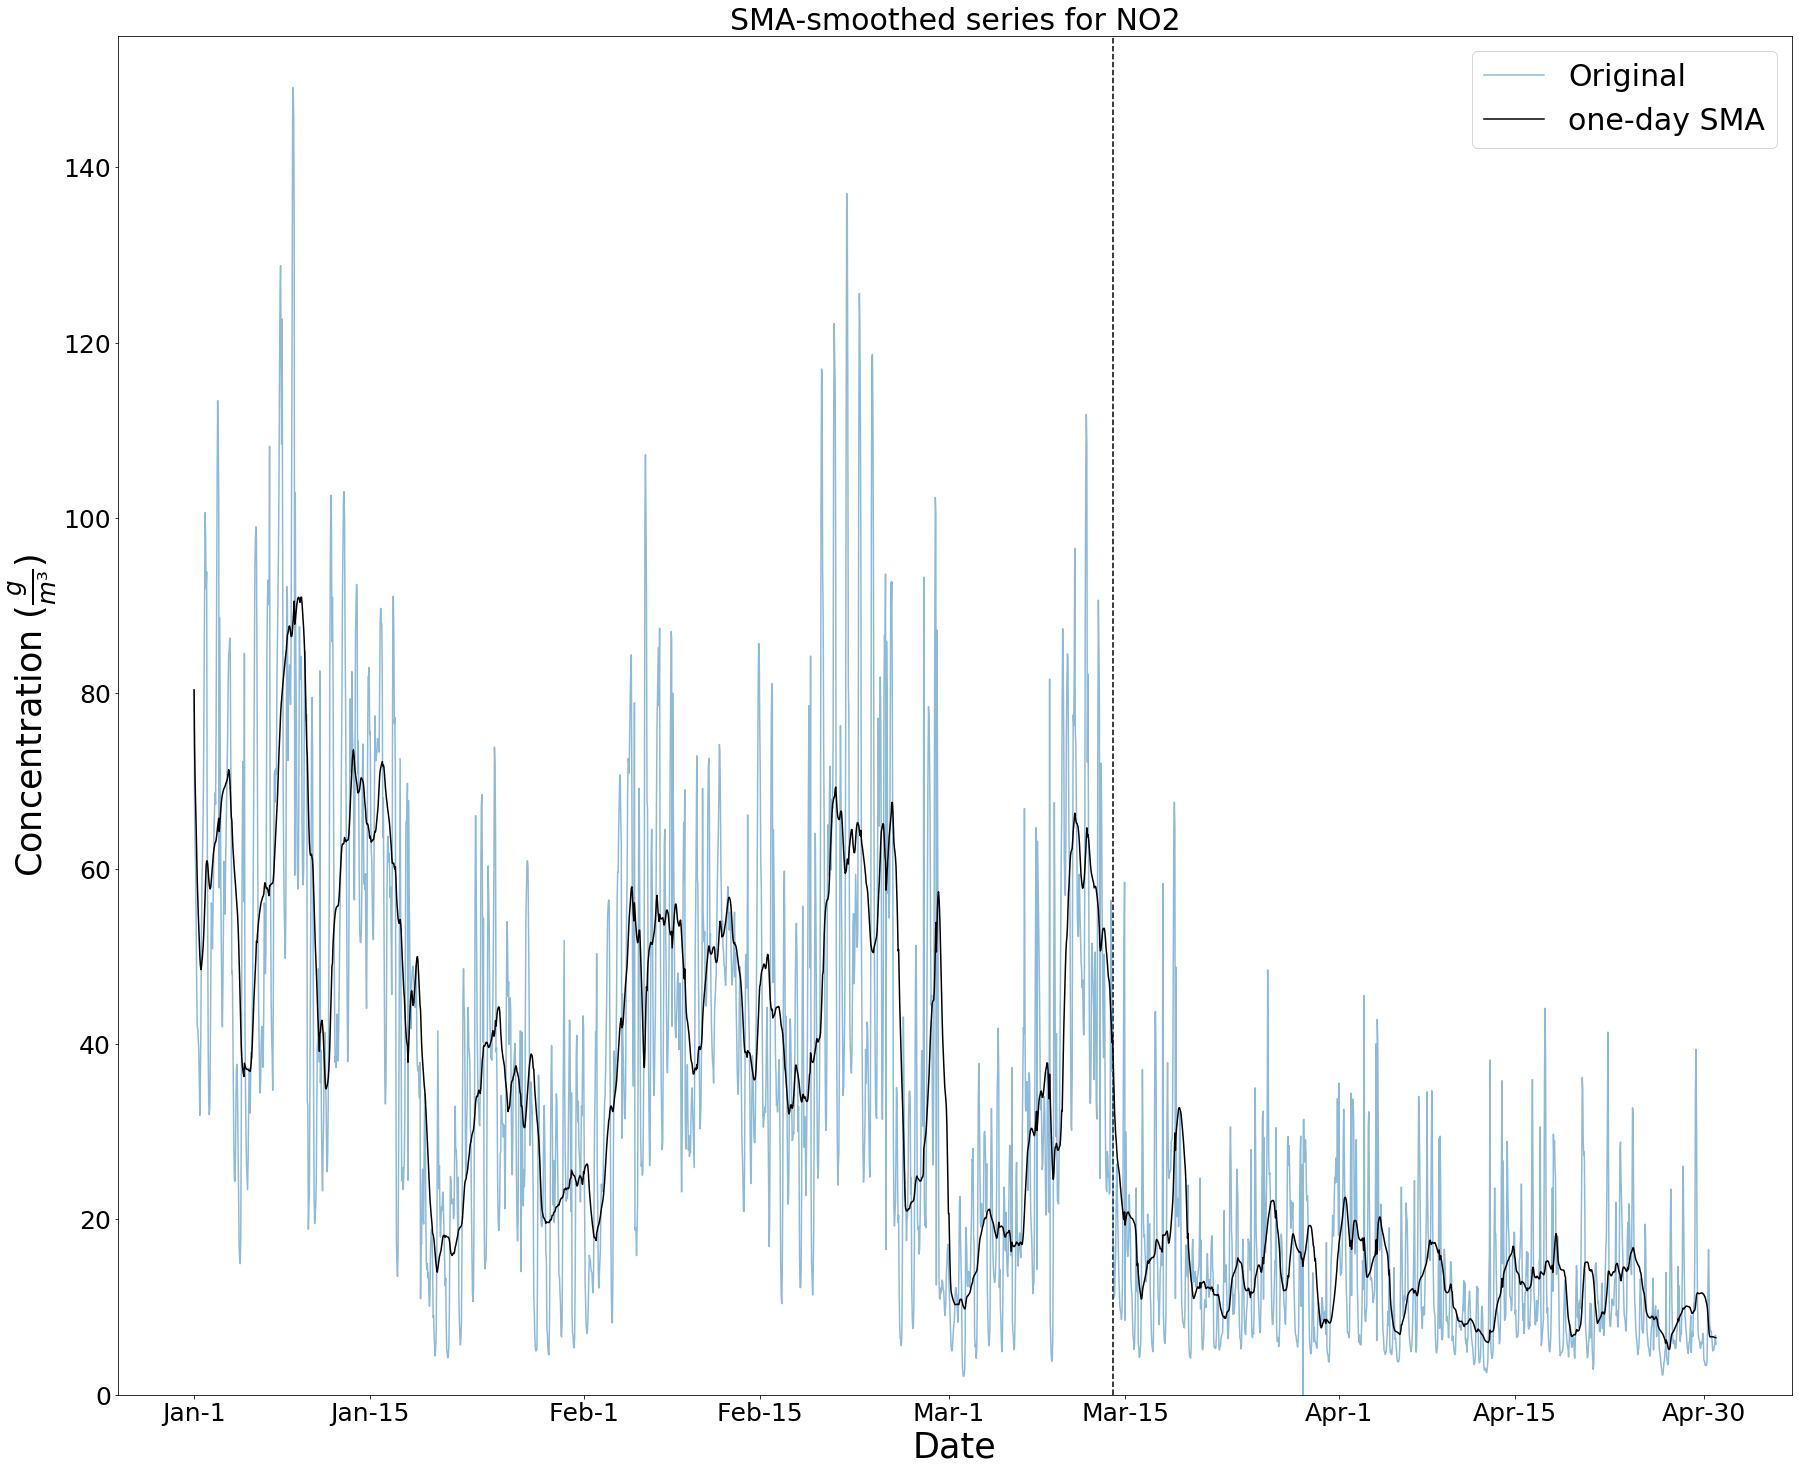

In [12]:
lockdown = dt.datetime(2020,3,14)

plt.figure(figsize=(30,25))
#sns.lineplot(df.index, df['concentracion'], color='blue', linestyle= ,label='original')
plt.plot(df.index, df['concentracion'], label='Original', alpha=0.5)
plt.plot(df.index, df['SMA'], label='one-day SMA', color='black')
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{g}{m³})$', fontsize=35)
plt.xticks(ticks=tick_pos, labels=tick_labels, fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0,155)
#plt.grid(color = 'black')
plt.title('SMA-smoothed series for ' + pollutant, fontsize=30)
plt.legend(fontsize=30)
plt.vlines(lockdown, ymin = 0, ymax = 155, linestyle='--');

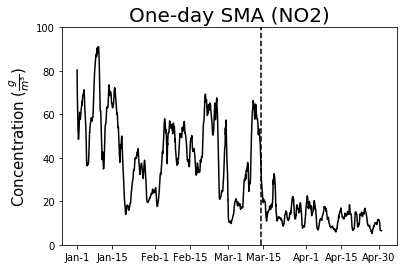

In [13]:
plt.plot(df.index, df['SMA'], label='one-day SMA', color='black')
plt.ylabel(r'Concentration $(\frac{g}{m³})$', fontsize=15)
plt.xticks(ticks=tick_pos, labels=tick_labels)
plt.ylim(0,100)
plt.title('One-day SMA (%s)'%(pollutant), fontsize=20)
plt.vlines(lockdown, ymin = 0, ymax = 100, linestyle='--');

The dotted line corresponds to March 14, when the lockdown was officially initiated. It can be seen that it is around this date that the concentration levels plummet to sub-20 values and, unlike the cyclic behavior that can be seen in previous months where the pollutant levels increased and decreased, after lockdown the fluctuations in NO2 concentrations diminish considerably. 

I'll plot the time series starting at the beginning of March so that the behavior can be more clearly seen. 

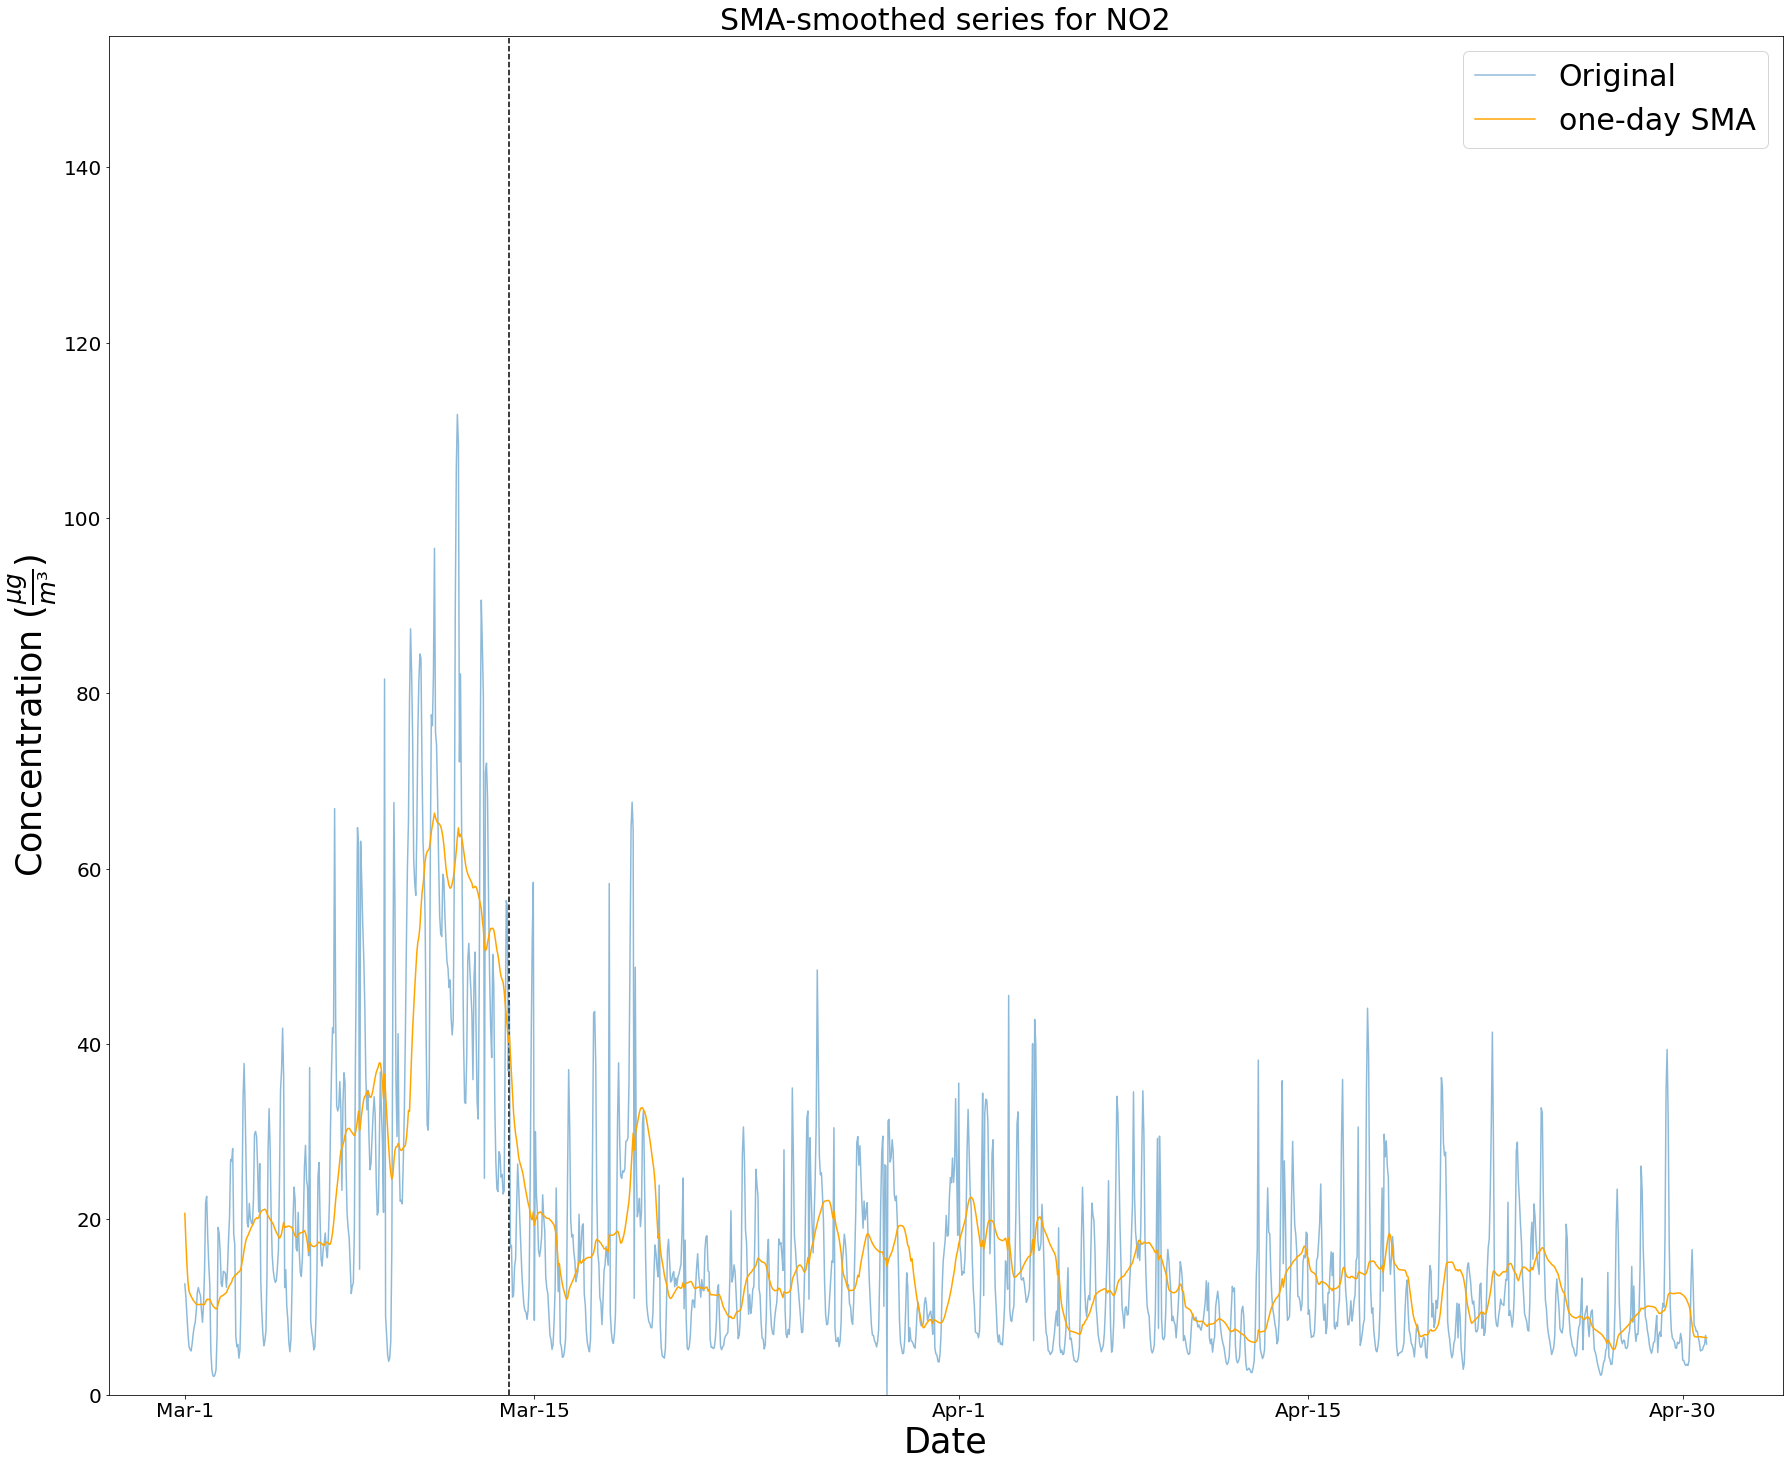

In [14]:
march1st = dt.datetime(2020,3,1)
df_after_march = df.loc[march1st:,:]
lockdown = dt.datetime(2020,3,14)

plt.figure(figsize=(30,25))
#sns.lineplot(df.index, df['concentracion'], color='blue', linestyle= ,label='original')
plt.plot(df_after_march.index, df_after_march['concentracion'].values, label='Original', alpha=0.5)
plt.plot(df_after_march.index, df_after_march['SMA'], label='one-day SMA', color='orange')
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=35)
plt.xticks(ticks=tick_pos, labels=tick_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,155)
#plt.grid(color = 'black')
plt.title('SMA-smoothed series for ' + pollutant, fontsize=30)
plt.vlines(lockdown, ymin = 0, ymax = 155, linestyle='--')
plt.legend(fontsize=30);

It can be seen that pollution levels were already starting to diminish, but this decrease was accelerated when lockdown began. Furthermore, It may be possible to model this behavior as as a constant after the values have "settled down".

In [15]:
del df_after_march

In [16]:
df_bf_lock = df.loc[:lockdown]
df_aft_lock = df.loc[lockdown:]

In [17]:
df_reg = df_aft_lock.loc[dt.datetime(2020,3,21):,:]

In [18]:
df_reg['Hours_after_lockdown'] = np.arange(len(df_reg))

In [19]:
model = sm.OLS.from_formula('concentracion ~ Hours_after_lockdown', data = df_reg)
linear_reg = model.fit()
b0, b1 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          concentracion   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     35.60
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           3.37e-09
Time:                        17:13:39   Log-Likelihood:                -3428.3
No. Observations:                 984   AIC:                             6861.
Df Residuals:                     982   BIC:                             6870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.0794      0.503     29.983      0.000      14.092      16.066
Hours_after_lockdown    -0.0053      0.001     -5.967      0.000      -0.007      -0.004
==============================================================================
Omnibus:                      238.513   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.902
Skew:                           1.410   Prob(JB):                    1.51e-102
Kurtosis:                       4.867   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
df_reg.head()

,concentracion,SMA,Hours_after_lockdown
dt,,,
2020-03-21 00:00:00,9.818182,12.202652,0
2020-03-21 01:00:00,17.636364,12.596591,1
2020-03-21 02:00:00,8.636364,12.731061,2
2020-03-21 03:00:00,5.318182,12.768939,3
2020-03-21 04:00:00,5.136364,12.803030,4


In [21]:
df_reg['reg_values'] = b0 + b1*df_reg['Hours_after_lockdown']

In [22]:
df_reg['resid'] = df_reg['concentracion'] - df_reg['reg_values']

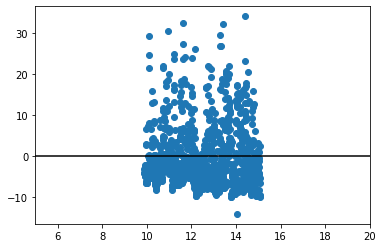

In [23]:
plt.scatter(df_reg['reg_values'].values, df_reg['resid'].values)
plt.xlim(5,20)
plt.hlines(0,5,20)

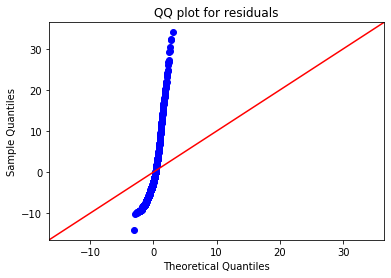

In [24]:
sm.qqplot(df_reg['resid'], line='45')
plt.title('QQ plot for residuals');

This regression was supposed to give information regarding how much the series differs from a constant after the pollutant values have settled, but although the regression and coefficients are statistically significant, the value for $R²$ and residual distributions point towards this regression not being particularly useful for concluding anything.

**Trend and seasonality**

I'll use the statsmodels seasonal decompose function to obtain a naive decomposition of the time series as a sum of trend, seasonality, and residuals. The trend was previously obtained on its own via moving averages, but this approach also allows one to obtain the other components.

In [50]:
res_bf = seasonal_decompose(df_bf_lock['concentracion'])
res_aft = seasonal_decompose(df_aft_lock['concentracion'])

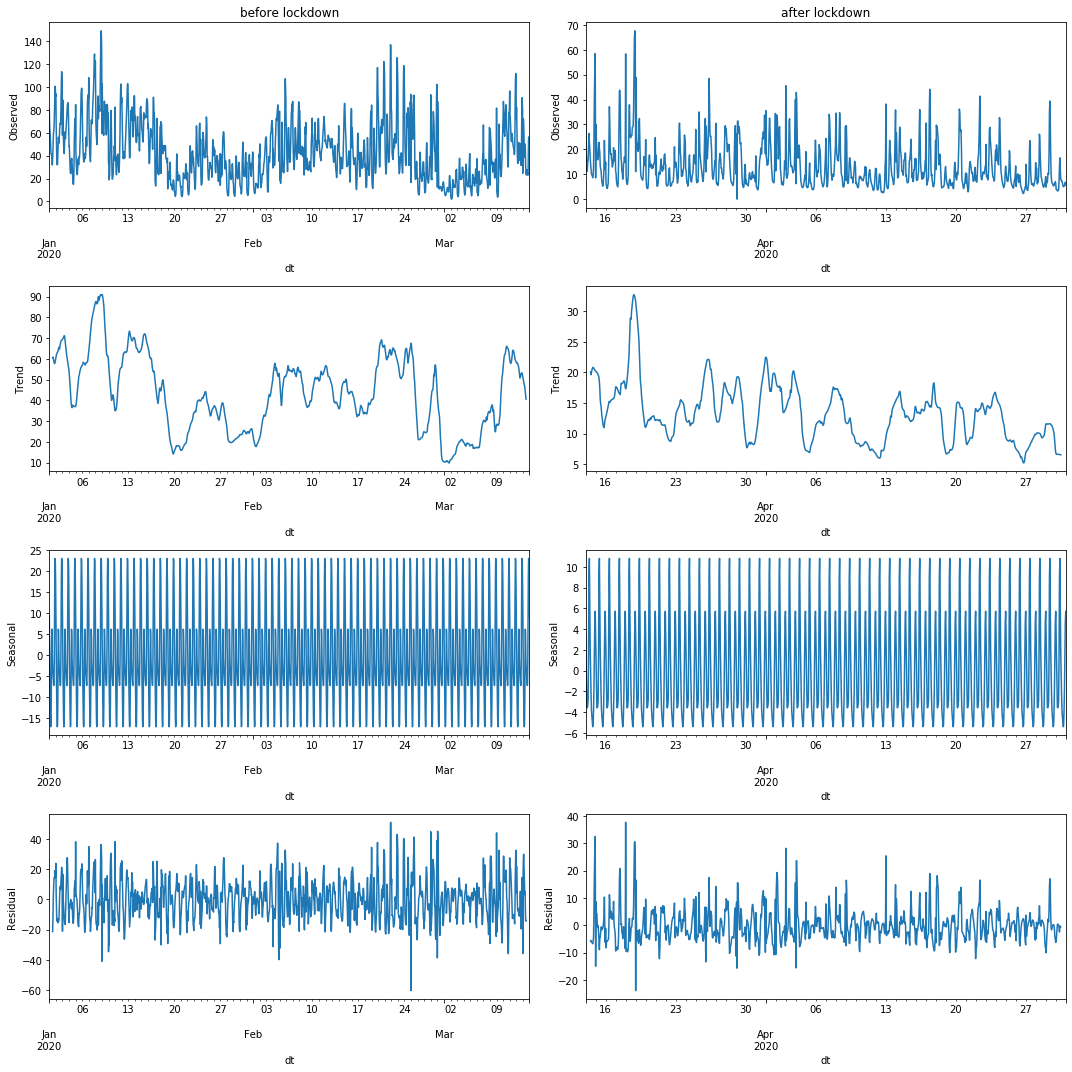

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (15,15))
axes[:,0] = seasonal_plot(res_bf, axes[:,0], 'before lockdown')
axes[:,1] = seasonal_plot(res_aft, axes[:,1], 'after lockdown')
plt.tight_layout()
plt.show()

The trend is similar to the smoothed series obtained by hand in the previous section. Once again, the concentration values after lockdown are lower than before. Of note is the presence of daily seasonality, consistent with the fact that people go to work at around the same time each day, so vehicles and factories emit pollutants in regular intervals. During lockdown, however, this did not change beyond simply having smaller amounts of pollutants in the atmosphere. So therefore during lockdown less people were going to work, but the economy did not stop completely

The residual basically contains all information pertaining to the random components of the time series. It can be observed that the magnitude of these components also diminishes after lockdown. Since the main source of NO2 is the combustion of fossil fuels, it's possible that this random component is mostly due to variations in the output of pollutants in this process, which would explain the decrease.

## Histograms

In [27]:
summ_stats_compare(df_bf_lock['concentracion'], df_aft_lock['concentracion'], 'Before lockdown',
                  'After lockdown')

,Before lockdown,After lockdown
count,1753.00,1152.00
mean,43.40,13.32
std,25.29,9.05
min,2.09,0.00
25%,24.78,6.86
50%,38.65,10.36
75%,58.61,17.10
max,149.09,67.59
skew,0.82,1.81
kurtosis,0.55,4.71


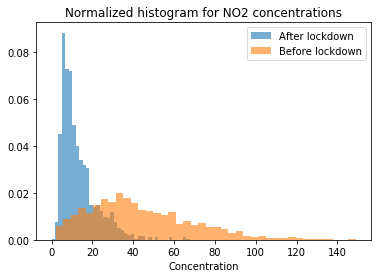

In [28]:
plt.hist(df_aft_lock['concentracion'].values, bins=40, density=True, 
         label='After lockdown', alpha=0.6)
plt.hist(df_bf_lock['concentracion'].values, bins=40, density=True,
         label='Before lockdown', alpha=0.6)
plt.xlabel('Concentration')
plt.title('Normalized histogram for %s concentrations'%(pollutant))
plt.legend();

The period before lockdown has considerably larger values of NO2 concentration, with its mean being approximately 40 $\frac{\mu g}{m^3}$ above that of the period after lockdown. The standard deviation before lockdown is also larger than after, and from the histograms it's seen that, in general, NO2 levels are more concentrated around a single small interval after lockdown than before. This can also be observed by comparing interquartile regions. The maximum values of both are also different in the same way. 

## Mean and median values comparison

In [29]:
mo_bf_lock_descr = df_bf_lock.groupby(df_bf_lock.index.month)['concentracion'].describe()
mo_aft_lock_descr = df_aft_lock.groupby(df_aft_lock.index.month)['concentracion'].describe()

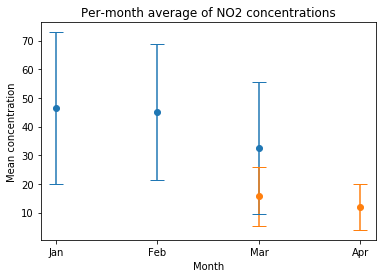

In [30]:
plt.errorbar(mo_bf_lock_descr.index, mo_bf_lock_descr['mean'], yerr=mo_bf_lock_descr['std'], 
             fmt = 'o', label='Before', capsize=7)
plt.errorbar(mo_aft_lock_descr.index, mo_aft_lock_descr['mean'], yerr=mo_aft_lock_descr['std'], 
             fmt = 'o', label='After', capsize=7)
plt.title('Per-month average of %s concentrations'%(pollutant))
plt.xlabel('Month')
plt.ylabel('Mean concentration')
plt.xticks(ticks=list(range(1,5)), labels=['Jan','Feb','Mar','Apr']);

In [31]:
df['mes'] = df.index.month

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'}
df['mes_nombre'] = df['mes'].apply(lambda x: month_map[x])
df['mes_nombre'] = df['mes'].apply(lambda x: month_map[x])

In [32]:
df['cuarent'] = (df.index > lockdown)

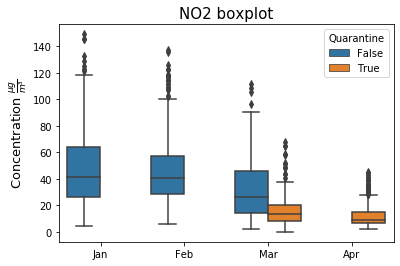

In [33]:
sns.boxplot(x='mes_nombre', y='concentracion', data=df, hue='cuarent')
plt.title('%s boxplot'%(pollutant), fontsize=15)
plt.ylabel(r'Concentration $\frac{\mu g}{m³}$', fontsize=13)
plt.xlabel('')
plt.legend(title='Quarantine') ;

From the above it can be seen that the mean and median values in quarantine are below those before it, and outside the error range in both cases (comparing different months) except for march, which could be exlained as the two distributions not being entirely independent at that point.

## Autocorrelation and seasonality

In [34]:
bf_lock_autocorr = [df_bf_lock['concentracion'].autocorr(tau) for tau in range(len(df_bf_lock))]
aft_lock_autocorr = [df_aft_lock['concentracion'].autocorr(tau) for tau in range(len(df_aft_lock))]

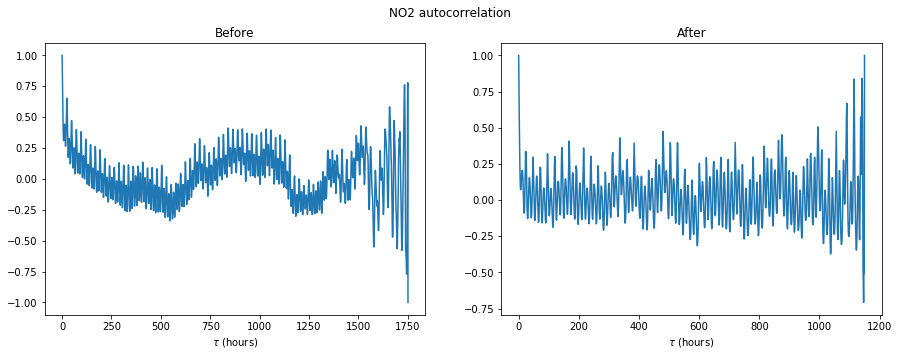

In [35]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation')

ax[0].plot(range(len(bf_lock_autocorr)), bf_lock_autocorr)
ax[0].set_title('Before')

ax[1].plot(range(len(aft_lock_autocorr)), aft_lock_autocorr)
ax[1].set_title('After')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)')

#plt.grid(color='black')

#plt.ylabel(r'ACF', fontsize=15)

I'll check for daily seasonality, taking an autocorrelation in a five-day window starting from ten days after the first measurement for both before and after quarantine started just to avoid any problems arising from lack of independence and the fact that the first couple of days in the before df correspond to the first days of the year, which are holidays.

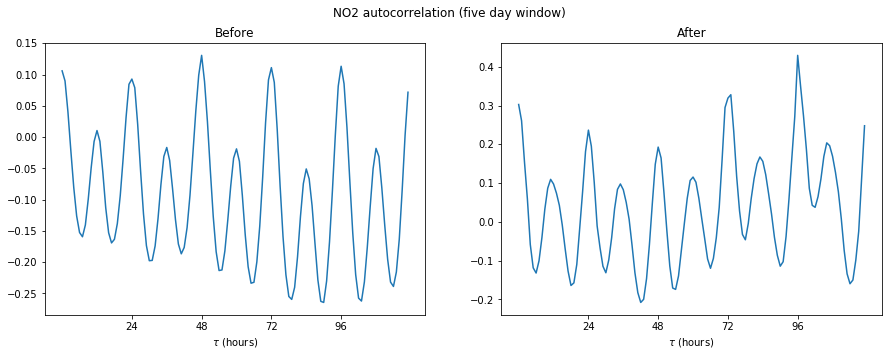

In [36]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation (five day window)')

ax[0].plot(range(5*24), bf_lock_autocorr[10*24:15*24])
ax[0].set_title('Before')

ax[1].plot(range(5*24), aft_lock_autocorr[10*24:15*24])
ax[1].set_title('After')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)')
    ax[i].set_xticks(list(range(24, 120, 24)))

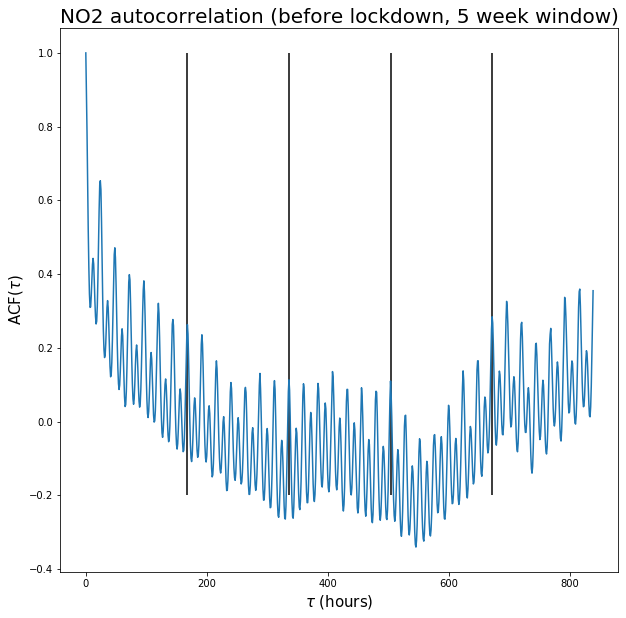

In [37]:
#Checking weekly seasonality

time_range = 5*7*24 #Five weeks

fig = plt.figure(figsize=(10,10))
plt.plot(range(time_range), bf_lock_autocorr[:time_range])
#plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (before lockdown, 5 week window)', fontsize=20)
plt.vlines(list(range(7*24, 5*7*24, 7*24)), -0.2, 1);

In [38]:
aft_lock_autocorr = [df_aft_lock['concentracion'].autocorr(tau) for tau in range(len(df_aft_lock))]

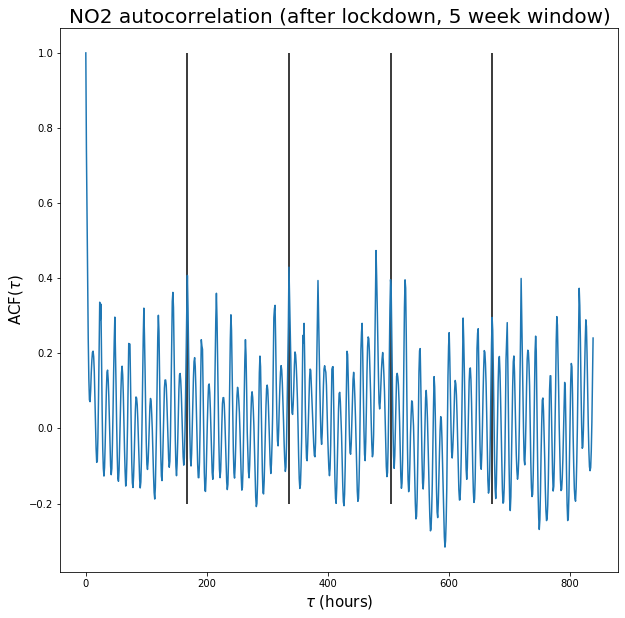

In [39]:
#Checking weekly seasonality

time_range = 5*7*24 #Five weeks

fig = plt.figure(figsize=(10,10))
plt.plot(range(time_range), aft_lock_autocorr[:time_range])
#plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (after lockdown, 5 week window)', fontsize=20)
plt.vlines(list(range(7*24, 5*7*24, 7*24)), -0.2, 1) ;

Comparing the behavior of the autocorrelation before and after the lockdown, it can be seen that the after series is less correlated (i.e. the values for the autocorrelation decrease faster with $\tau$) than the before series. The daily periodicity associated with the workday is largely intact, however. The weaker correlation seems to suggest a stronger random component in the after series.

## Poincaré Diagram

In [40]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_bf_lock['concentracion_shift'] = df_bf_lock['concentracion'].shift(1)
df_bf_lock[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.899711
concentracion_shift,0.899711,1.000000


The correlation is quite strong. Doing a linear regression:

In [41]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_bf_lock)
linear_reg_bf = model.fit()
linear_reg_bf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.809
Model:                             OLS   Adj. R-squared:                  0.809
Method:                  Least Squares   F-statistic:                     7435.
Date:                 Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                         17:13:48   Log-Likelihood:                -6693.5
No. Observations:                 1752   AIC:                         1.339e+04
Df Residuals:                     1750   BIC:                         1.340e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3472      0.524      8.293      0.000       3.319       5.375
concentracion     0.9003      0.010     86.229      0.000       0.880       0.921
==============================================================================
Omnibus:                      534.377   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8957.719
Skew:                           0.976   Prob(JB):                         0.00
Kurtosis:                      13.904   Cond. No.                         99.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now after lockdown.

---

In [42]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_aft_lock['concentracion_shift'] = df_aft_lock['concentracion'].shift(1)
df_aft_lock[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.743114
concentracion_shift,0.743114,1.000000


The correlation is still strong, but not as much as before lockdown. Doing a linear regression:

In [43]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_aft_lock)
linear_reg_aft = model.fit()
linear_reg_aft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.552
Method:                  Least Squares   F-statistic:                     1417.
Date:                 Thu, 23 Jul 2020   Prob (F-statistic):          1.09e-202
Time:                         17:13:48   Log-Likelihood:                -3706.1
No. Observations:                 1151   AIC:                             7416.
Df Residuals:                     1149   BIC:                             7426.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4008      0.319     10.675      0.000       2.776       4.026
concentracion     0.7468      0.020     37.643      0.000       0.708       0.786
==============================================================================
Omnibus:                      639.542   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14273.962
Skew:                           2.090   Prob(JB):                         0.00
Kurtosis:                      19.738   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

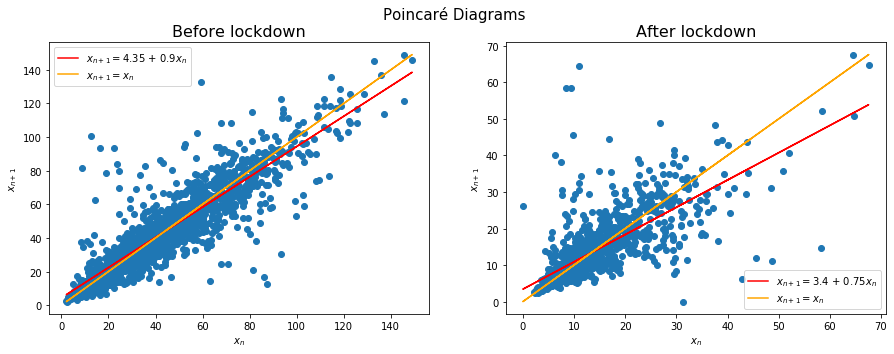

In [44]:
poincare_plot(df_bf_lock[['concentracion','concentracion_shift']].values,
             df_aft_lock[['concentracion','concentracion_shift']].values,
              linear_reg_bf.params, linear_reg_aft.params,
              'Before lockdown', 'After lockdown')

The values appear to be slightly more spread out after lockdown, which can also be seen from the correlation coefficient. Furthermore, the line deviates slightly more from the identity, which points towards a more random behavior.

---
---
---

## SSA

Next I'll examine the variation on both sides with a scree diagram.

In [45]:
window = 24*14 #two weeks
U,S,V = traj_matrix_SVD(df_bf_lock['concentracion'].values, window)

V contains the principal components, S the singular values

In [46]:
eigenvals = S**2
total_sum = eigenvals.sum(axis=0)
for i in range(len(eigenvals)):
    retained_var = eigenvals[i:].sum(axis=0)/total_sum
    print(i, retained_var)
    if retained_var < 0.2:
        break

0 [1.]
1 [0.21713417]
2 [0.18643092]


In [47]:
#Calculating the reduced data vector keeping 21% of the variance
V_red = V[:,:2]
red_data_bf = df_bf_lock['concentracion']@V_red

Exception: Dot product shape mismatch, (1753,) vs (1417, 2)

In [ ]:
plt.plot(red_data_bf.index, red_data_bf.values)

In [ ]:
ax = plt.axes()
plt.scatter(np.arange(len(S)), S)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$ln(\sigma(k))$')
plt.title('Scree diagram (before lockdown), window=2 weeks')
plt.vlines(97, 0, S[0], linestyle = '--') ;

In [ ]:
# First 110 values to more easily see the scree
ax = plt.axes()
plt.scatter(np.arange(len(S[:110])), S[:110])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$ln(\sigma(k))$')
plt.title('Scree diagram (before lockdown), window=2 weeks')
#plt.vlines(97, 0, S[0], linestyle = '--') ;

In [ ]:
U,S,V = traj_matrix_SVD(df_aft_lock['concentracion'].values, window)

In [ ]:
eigenvals = S**2
total_sum = eigenvals.sum(axis=0)
for i in range(len(eigenvals)):
    retained_var = eigenvals[i:].sum(axis=0)/total_sum
    print(i, retained_var)
    if retained_var < 0.2:
        break

In [ ]:
#S es un vector con los valores singulares. Se grafica el diagrama de scree
ax = plt.axes()
plt.scatter(np.arange(len(S)), S)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$\sigma(k)$')
plt.title('Scree diagram (after lockdown)');